In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [175]:
# --- Data Loading ---
# Se carga el archivo de datos procesados.
path = r'../data/processed/data_processed_v2_NoAcum_Total.csv'
alzheimer_df = pd.read_csv(path)

In [176]:
# Se agrupan los datos a nivel nacional sumando los casos de todos los estados.
df_national = alzheimer_df.groupby(['Year', 'Week', 'Date'], as_index=False)['total_cases'].sum()

print("Información del DataFrame Nacional:")
df_national.info()
df_national.head()

Información del DataFrame Nacional:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         572 non-null    int64  
 1   Week         572 non-null    int64  
 2   Date         572 non-null    object 
 3   total_cases  572 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 18.0+ KB


,Year,Week,Date,total_cases
0,2014,2,2014-01-13,4.0
1,2014,3,2014-01-20,29.0
2,2014,4,2014-01-27,47.0
3,2014,5,2014-02-03,36.0
4,2014,6,2014-02-10,42.0


In [177]:
# Se crea una copia para el preprocesamiento del modelo.
df_ts = df_national.copy()

# Se convierte la columna 'Date' a formato datetime.
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts = df_ts.sort_values('Date')
df_ts.head()

,Year,Week,Date,total_cases
0,2014,2,2014-01-13,4.0
1,2014,3,2014-01-20,29.0
2,2014,4,2014-01-27,47.0
3,2014,5,2014-02-03,36.0
4,2014,6,2014-02-10,42.0


In [178]:
# Se corrigen duplicados en las fechas agregando sus valores.
df_ts = df_ts.groupby('Date', as_index=False)['total_cases'].sum()
print(df_ts['Date'].duplicated().sum())

# Se establece la columna 'Date' como el índice del DataFrame.
df_ts = df_ts.set_index('Date')

0


In [179]:
# Se asegura que la frecuencia del índice sea semanal (anclada al LUNES: 'W-MON').
df_ts = df_ts.asfreq('W-MON')

# Se cuenta el número de registros DESPUÉS de forzar la frecuencia
registros_despues = len(df_ts)
print(f"Número total de semanas después de asegurar la frecuencia: {registros_despues}")

# Se calculan los registros nuevos que se crearon con valor Nulo (NaN)
registros_nuevos_nan = df_ts['total_cases'].isnull().sum()

print(f"\nNúmero de semanas nuevas que se añadieron y rellenaron: {registros_nuevos_nan}")

Número total de semanas después de asegurar la frecuencia: 572

Número de semanas nuevas que se añadieron y rellenaron: 2


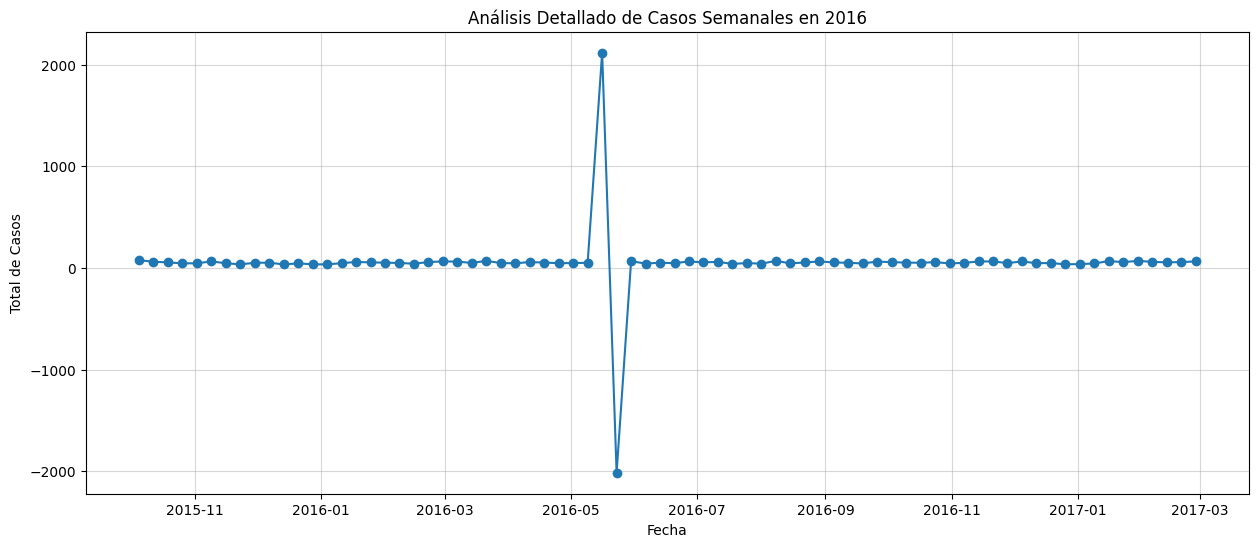

Semanas con los valores más altos en 2016:
Date
2016-05-16    2118.0
2016-03-21      70.0
2016-08-08      70.0
2016-05-30      67.0
2016-02-29      64.0
Name: total_cases, dtype: float64


In [180]:
# --- Diagnóstico Visual de Outliers en 2016 ---

# Se crea un DataFrame enfocado en el período de interés (2016 y sus alrededores).
df_2016 = df_ts['2015-10-01':'2017-03-01'].copy()

# Se visualiza el período para identificar los picos.
plt.figure(figsize=(15, 6))
plt.plot(df_2016.index, df_2016['total_cases'], marker='o', linestyle='-')
plt.title('Análisis Detallado de Casos Semanales en 2016')
plt.xlabel('Fecha')
plt.ylabel('Total de Casos')
plt.grid(True, alpha=0.5)
plt.show()

# Se identifican las semanas con los valores más altos en 2016.
print("Semanas con los valores más altos en 2016:")
print(df_ts[df_ts.index.year == 2016]['total_cases'].nlargest(5))


Valor del outlier corregido por interpolación.


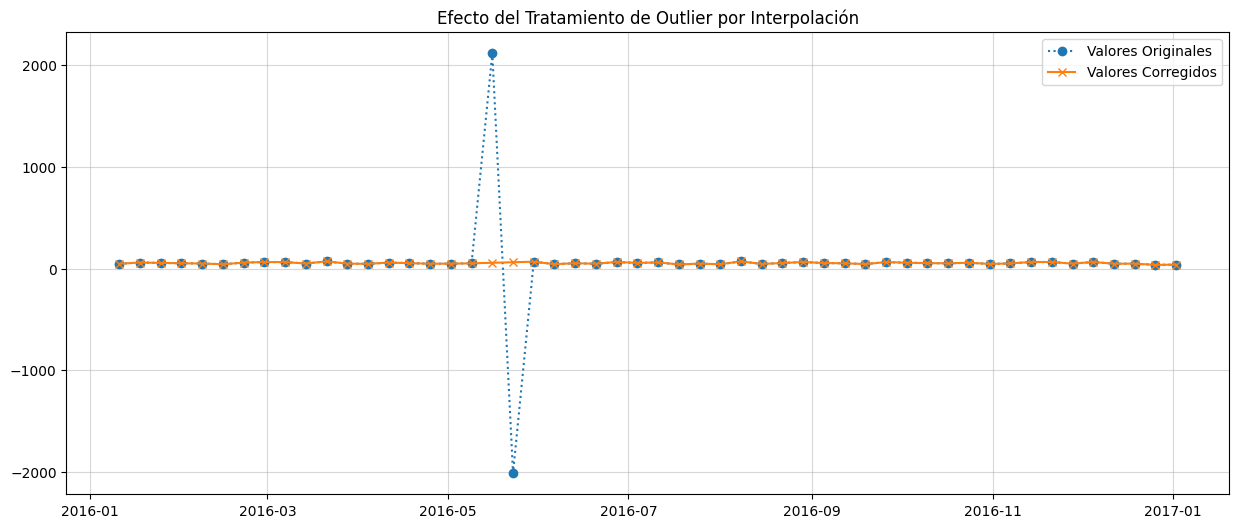

In [181]:
# --- Tratamiento Específico para Outliers de 2016 ---

# Se identifican las fechas exactas de los outliers.
# Por ejemplo, si el outlier principal fue el 2016-12-25:
fechas_outliers = pd.to_datetime(['2016-05-16', '2016-05-23'])

# Se crea una copia de la columna original para comparar después.
df_ts['total_cases_original'] = df_ts['total_cases']

# Se reemplaza el valor del outlier con NaN (Not a Number).
df_ts.loc[df_ts.index.isin(fechas_outliers), 'total_cases'] = np.nan

# Se aplica interpolación basada en el tiempo para rellenar el hueco.
df_ts['total_cases'] = df_ts['total_cases'].interpolate(method='time')

print("\nValor del outlier corregido por interpolación.")

# --- Visualización del Antes y Después ---
plt.figure(figsize=(15, 6))
plt.plot(df_ts['2016-01-10':'2017-01-03'].index, df_ts['total_cases_original']['2016-01-10':'2017-01-03'], marker='o', linestyle=':', label='Valores Originales')
plt.plot(df_ts['2016-01-10':'2017-01-03'].index, df_ts['total_cases']['2016-01-10':'2017-01-03'], marker='x', linestyle='-', label='Valores Corregidos')
plt.title('Efecto del Tratamiento de Outlier por Interpolación')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# Se elimina la columna original de respaldo.
df_ts = df_ts.drop(columns=['total_cases_original'])

In [182]:
# Se calcula el punto de corte para la división 80/20.
split_idx = int(len(df_ts) * 0.8)

# Se dividen los datos.
train_df = df_ts[:split_idx].copy()
test_df  = df_ts[split_idx:].copy()

# Se verifica la dimensión de cada conjunto.
print(f"Dimensiones de los datos de entrenamiento: {train_df.shape}")
print(f"Dimensiones de los datos de prueba:     {test_df.shape}")

Dimensiones de los datos de entrenamiento: (457, 1)
Dimensiones de los datos de prueba:     (115, 1)


In [183]:
warnings.filterwarnings("ignore") # Se ignoran las advertencias para una salida más limpia

# Se definen los rangos de p, d, q a probar.
# Se usan rangos pequeños (0-2) para que la búsqueda sea razonablemente rápida.
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q))

# Se define el componente estacional (P,D,Q,s)
# Como la estacionalidad es anual en datos semanales, 's' es 52.
# Se prueba con una combinación estacional común como punto de partida.
seasonal_pdq = [(1, 1, 1, 52)]

print("Realizando Grid Search para encontrar los mejores parámetros SARIMAX...")
print(f"Combinaciones de (p,d,q) a probar: {len(pdq)}")

# Se inicializan variables para guardar el mejor resultado
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

# Se itera a través de todas las combinaciones de parámetros no estacionales
for param in pdq:
    # El componente estacional es fijo en este ejemplo
    for param_seasonal in seasonal_pdq:
        try:
            # Se crea y entrena el modelo SARIMAX
            mod = SARIMAX(train_df['total_cases'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)

            # Se imprime el resultado y se guarda si es el mejor hasta ahora
            print(f'SARIMAX{param}x{param_seasonal} - AIC:{results.aic:.2f}')
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal

        except Exception as e:
            # Se ignoran las combinaciones que causan errores
            continue

print(f"\nMejor modelo encontrado: SARIMAX{best_pdq}x{best_seasonal_pdq} con un AIC de: {best_aic:.2f}")

# Se guardan los parámetros óptimos para el siguiente paso
best_order = best_pdq
best_seasonal_order = best_seasonal_pdq

Realizando Grid Search para encontrar los mejores parámetros SARIMAX...
Combinaciones de (p,d,q) a probar: 8
SARIMAX(0, 0, 0)x(1, 1, 1, 52) - AIC:3085.61
SARIMAX(0, 0, 1)x(1, 1, 1, 52) - AIC:3020.64
SARIMAX(0, 1, 0)x(1, 1, 1, 52) - AIC:3059.72
SARIMAX(0, 1, 1)x(1, 1, 1, 52) - AIC:2835.44
SARIMAX(1, 0, 0)x(1, 1, 1, 52) - AIC:2972.86
SARIMAX(1, 0, 1)x(1, 1, 1, 52) - AIC:2840.98
SARIMAX(1, 1, 0)x(1, 1, 1, 52) - AIC:2902.71
SARIMAX(1, 1, 1)x(1, 1, 1, 52) - AIC:2825.12

Mejor modelo encontrado: SARIMAX(1, 1, 1)x(1, 1, 1, 52) con un AIC de: 2825.12


In [184]:
# Se parte de los datos de entrenamiento (train_df), prueba (test_df)
# y los mejores parámetros encontrados (best_order, best_seasonal_order).

# Se entrena el modelo SARIMAX final y se generan las predicciones ---

print("Entrenando el modelo final con los mejores parámetros...")
# Se crea el modelo SARIMAX con los mejores parámetros encontrados.
final_model = sm.tsa.statespace.SARIMAX(train_df['total_cases'],
                                        order=best_order,
                                        seasonal_order=best_seasonal_order,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

# Se entrena el modelo.
results = final_model.fit(disp=False)
print(results.summary()) # Se imprime un resumen del modelo final entrenado.

# Se generan las predicciones para el número de pasos correspondiente al tamaño del test set.
# get_forecast() también calcula los intervalos de confianza.
forecast_obj = results.get_forecast(steps=len(test_df))

# Se extraen las predicciones y los intervalos de confianza.
y_pred = forecast_obj.predicted_mean

print("\nPredicciones generadas exitosamente.")

Entrenando el modelo final con los mejores parámetros...
                                     SARIMAX Results                                      
Dep. Variable:                        total_cases   No. Observations:                  457
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -1407.562
Date:                            Sun, 19 Oct 2025   AIC                           2825.125
Time:                                    18:44:45   BIC                           2844.415
Sample:                                01-13-2014   HQIC                          2832.803
                                     - 10-10-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2316      0.048     -4.810      0.000   


Número de puntos válidos para la evaluación: 115
MAE:  14.80
RMSE: 18.40
MAPE: 40.09%


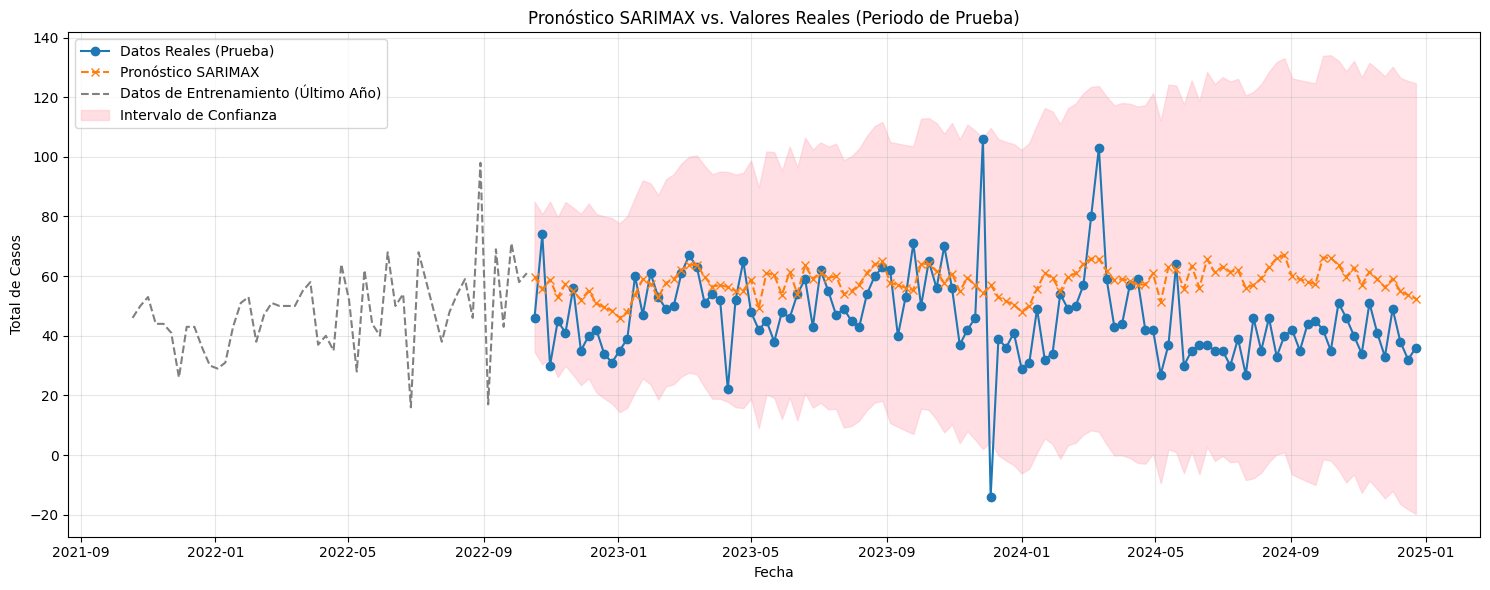

In [185]:
# Se calculan las métricas y se visualiza el rendimiento

# Se extraen los valores reales y las predicciones.
y_true = test_df['total_cases']
y_pred = forecast_obj.predicted_mean

# Se crea un DataFrame de evaluación para alinear los datos por fecha (índice).
eval_df = pd.DataFrame({'Actual': y_true, 'Forecast': y_pred})

# Se eliminan las filas donde CUALQUIERA de los dos valores sea NaN.
eval_df.dropna(inplace=True)

print(f"\nNúmero de puntos válidos para la evaluación: {len(eval_df)}")

# Se verifica que queden datos después de la limpieza antes de calcular.
if len(eval_df) > 0:
    mae = mean_absolute_error(eval_df['Actual'], eval_df['Forecast'])
    rmse = np.sqrt(mean_squared_error(eval_df['Actual'], eval_df['Forecast']))
    mape = mean_absolute_percentage_error(eval_df['Actual'], eval_df['Forecast']) * 100

    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # --- Visualización – SARIMAX Forecast vs Actuals (Zoom en el Test Set) ---
    confidence_intervals = forecast_obj.conf_int()
    
    plt.figure(figsize=(15, 6))
    
    # Se grafican los datos reales y el pronóstico del conjunto de prueba.
    plt.plot(eval_df.index, eval_df['Actual'], 'o-', label='Datos Reales (Prueba)')
    plt.plot(eval_df.index, eval_df['Forecast'], 'x--', label='Pronóstico SARIMAX')
    
    # Se añade una porción de los datos de entrenamiento para dar contexto.
    plt.plot(train_df.index[-52:], train_df['total_cases'][-52:], label='Datos de Entrenamiento (Último Año)', color='gray', linestyle='--')
    
    # Se grafican los intervalos de confianza.
    plt.fill_between(confidence_intervals.index,
                     confidence_intervals.iloc[:, 0],
                     confidence_intervals.iloc[:, 1], color='pink', alpha=.5,
                     label='Intervalo de Confianza')

    plt.xlabel('Fecha'); plt.ylabel('Total de Casos')
    plt.title('Pronóstico SARIMAX vs. Valores Reales (Periodo de Prueba)')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

else:
    print("Error: No hay datos válidos para la evaluación después de eliminar los NaNs.")